<a href="https://colab.research.google.com/github/MimiSyam/FYP/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

directory = '/content/drive/MyDrive/VGG19/skinTone_type_all'
class_names = os.listdir(directory)
num_classes = len(class_names)

In [3]:
import cv2
import glob
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Set the image size for VGG19
imSize = 224

In [5]:
# Lists to store images and labels
train_images = []
train_labels = []

In [ ]:
# Initialize an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [6]:
for class_index, class_name in enumerate(class_names):
    class_dir = os.path.join(directory, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        fundIm = cv2.imread(image_path)
        resizeIm = cv2.resize(fundIm, (imSize, imSize))  # Resize image to desired size

        #Apply data augmentation
        #img_batch = np.expand_dims(resizeIm, axis=0)  # Add batch dimension
        #aug_iter = datagen.flow(img_batch, batch_size=1)
        #augmented_images = [next(aug_iter)[0] for _ in range(10)]  # Generate 10 augmented images


        #train_images.extend(augmented_images)
        #train_labels.extend([class_index] * len(augmented_images))

        train_images.append(resizeIm)
        train_labels.append(class_index)

In [7]:
# Convert lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [8]:
# Normalize RGB values to [0, 1]
train_images = train_images.astype('float32') / 255.0

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def conv_block(x, filters, kernel_size, strides=(1, 1), padding="same"):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def identity_block(x, filters, kernel_size):
    shortcut = x
    x = conv_block(x, filters[0], (1, 1))
    x = conv_block(x, filters[1], kernel_size)
    x = Conv2D(filters[2], (1, 1))(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x, shortcut])
    x = ReLU()(x)
    return x

def projection_block(x, filters, kernel_size, strides=(2, 2)):
    shortcut = x
    x = conv_block(x, filters[0], (1, 1), strides=strides)
    x = conv_block(x, filters[1], kernel_size)
    x = Conv2D(filters[2], (1, 1))(x)
    shortcut = Conv2D(filters[2], (1, 1), strides=strides)(shortcut)
    shortcut = BatchNormalization()(shortcut)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x, shortcut])
    x = ReLU()(x)
    return x

input_shape = (224, 224, 3)
input_tensor = Input(shape=input_shape)

x = conv_block(input_tensor, 64, (7, 7), strides=(2, 2))
x = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

x = projection_block(x, [64, 64, 256], 3, strides=(1, 1))
x = identity_block(x, [64, 64, 256], 3)
x = identity_block(x, [64, 64, 256], 3)

x = projection_block(x, [128, 128, 512], 3)
x = identity_block(x, [128, 128, 512], 3)
x = identity_block(x, [128, 128, 512], 3)
x = identity_block(x, [128, 128, 512], 3)

x = projection_block(x, [256, 256, 1024], 3)
x = identity_block(x, [256, 256, 1024], 3)
x = identity_block(x, [256, 256, 1024], 3)
x = identity_block(x, [256, 256, 1024], 3)
x = identity_block(x, [256, 256, 1024], 3)

x = projection_block(x, [512, 512, 2048], 3)
x = identity_block(x, [512, 512, 2048], 3)
x = identity_block(x, [512, 512, 2048], 3)

x = GlobalAveragePooling2D()(x)
output_tensor = Dense(4, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 64)         0         ['batch_normalization[0][0

In [10]:
from keras.optimizers import Adam
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [12]:
# Convert labels to one-hot encoded format
label_to_id = {class_names: idx for idx, class_names in enumerate(np.unique(train_labels))}
train_labels_encoded = np.array([label_to_id[class_names] for class_names in train_labels])
train_labels_onehot = to_categorical(train_labels_encoded)

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels_onehot, test_size=0.2, random_state=42)

In [14]:
# Train the model
batch_size = 32
epochs = 50

In [15]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/50
28/28 [==============================] - 54s 435ms/step - loss: 0.6020 - accuracy: 0.5913 - val_loss: 0.7434 - val_accuracy: 0.2318
Epoch 2/50
28/28 [==============================] - 8s 293ms/step - loss: 0.2544 - accuracy: 0.8139 - val_loss: 2.4882 - val_accuracy: 0.2318
Epoch 3/50
28/28 [==============================] - 8s 295ms/step - loss: 0.2381 - accuracy: 0.8288 - val_loss: 3.9012 - val_accuracy: 0.2318
Epoch 4/50
28/28 [==============================] - 8s 296ms/step - loss: 0.1443 - accuracy: 0.9041 - val_loss: 4.8017 - val_accuracy: 0.2318
Epoch 5/50
28/28 [==============================] - 8s 298ms/step - loss: 0.1460 - accuracy: 0.9030 - val_loss: 9.1984 - val_accuracy: 0.2318
Epoch 6/50
28/28 [==============================] - 8s 299ms/step - loss: 0.1190 - accuracy: 0.9258 - val_loss: 8.3692 - val_accuracy: 0.2318
Epoch 7/50
28/28 [==============================] - 8s 300ms/step - loss: 0.0701 - accuracy: 0.9578 - val_loss: 10.6162 - val_accuracy: 0.2318
Epoc

In [16]:
# Evaluate the model on the testing set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

9/9 [==============================] - 2s 186ms/step - loss: 2.0507 - accuracy: 0.5292
Test Loss: 2.0507359504699707
Test Accuracy: 0.529197096824646


In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

<Figure size 640x480 with 0 Axes>

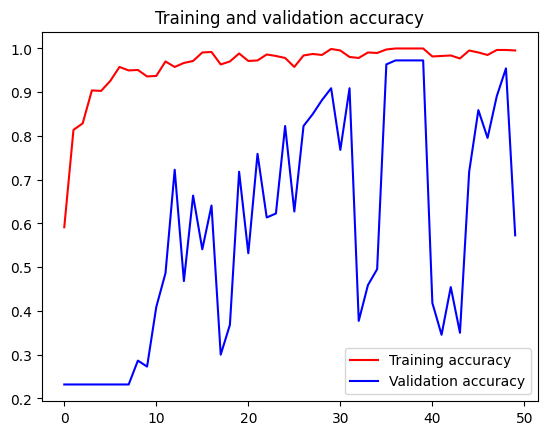

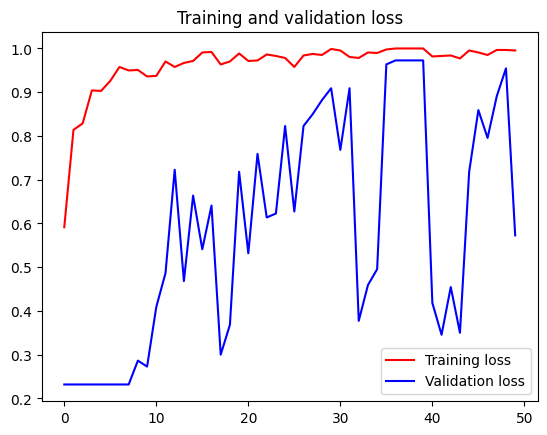

<Figure size 640x480 with 0 Axes>

In [18]:
# Retrieve a list of results on training and test data sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))  # Get the number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc = 0)
plt.figure()

# Plot training and validation lost per epoch
plt.plot(epochs, acc, 'r', label = 'Training loss')
plt.plot(epochs, val_acc, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend(loc = 0)
plt.figure()

9/9 [==============================] - 2s 93ms/step


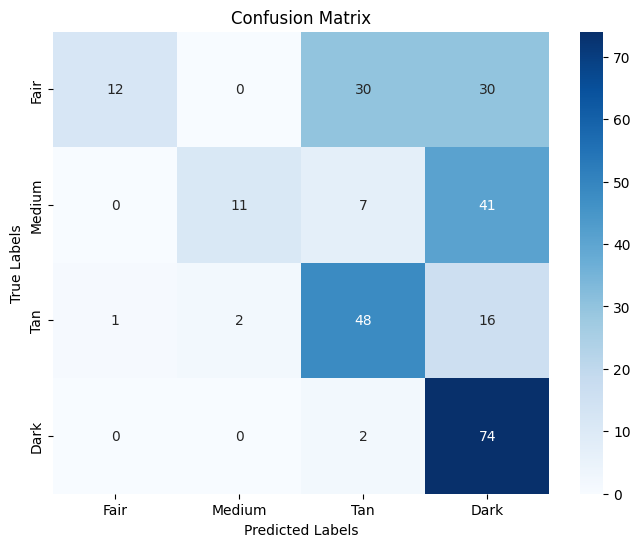

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Perform prediction on the test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Convert test_labels to integer format
test_labels_int = np.argmax(y_test, axis=1)

# Create a confusion matrix
cm = confusion_matrix(test_labels_int, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [20]:
def calculate_accuracy(confusion_matrix):
    # Extract the values from the confusion matrix
    true_positives = np.diag(confusion_matrix)
    total_predictions = np.sum(confusion_matrix)

    # Calculate the accuracy
    accuracy = np.sum(true_positives) / total_predictions

    return accuracy

# Calculate the accuracy using the confusion matrix
accuracy = calculate_accuracy(cm)

# Print the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.5291970802919708
